In [1]:
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import eurostat
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter

# Chain linked volumes (2010), euro per capita

code = "SDG_08_10"
filter_pars = {"unit": "CLV10_EUR_HAB"}
data_real_gdp = eurostat.get_data_df(code, filter_pars=filter_pars)
data_real_gdp = data_real_gdp.drop(columns=["freq", "na_item", "unit"])
data_real_gdp = data_real_gdp.rename(columns={"geo\\TIME_PERIOD": "GeoName"})
data_real_gdp = data_real_gdp[data_real_gdp["GeoName"].isin(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK'])]
data_real_gdp = data_real_gdp.melt(["GeoName"], var_name="Year", value_name="Real GDP per capita")
data_real_gdp = data_real_gdp.dropna(subset=["Real GDP per capita"])
data_real_gdp["log GDP per capita"] = numpy.log(data_real_gdp["Real GDP per capita"])
data_real_gdp = data_real_gdp[data_real_gdp["Year"] <= "2022"]
data_real_gdp[data_real_gdp["Year"] == "2022"]
data_real_gdp.to_csv("data/Europe_RealGDP.csv")
data_real_gdp

/var/folders/gt/hp_y969x7hgchgtzlj0y7nhc0000gn/T/ipykernel_25404/3229397556.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,GeoName,Year,Real GDP per capita,log GDP per capita
0,AT,2000,31510.0,10.358060
1,BE,2000,29890.0,10.305279
2,BG,2000,2990.0,8.003029
3,CY,2000,20130.0,9.909967
4,CZ,2000,11440.0,9.344871
...,...,...,...,...
616,PT,2022,18970.0,9.850614
617,RO,2022,10030.0,9.213336
618,SE,2022,45100.0,10.716638
619,SI,2022,21790.0,9.989206


In [2]:
data_real_gdp_sigma = data_real_gdp.groupby("Year")["log GDP per capita"].std().to_frame()
data_real_gdp_sigma["Region"] = "Europe"
data_real_gdp_sigma.to_csv("data/Europe_sigma.csv")
data_real_gdp_sigma

,log GDP per capita,Region
Year,,
2000,0.827390,Europe
2001,0.811190,Europe
2002,0.789876,Europe
2003,0.768051,Europe
2004,0.750104,Europe
2005,0.729187,Europe
2006,0.710690,Europe
2007,0.693052,Europe
2008,0.671956,Europe


In [3]:
data_real_gdp["GeoName"].unique()

array(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI',
       'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL',
       'PT', 'RO', 'SE', 'SI', 'SK'], dtype=object)

In [4]:
first_year = "2000"
last_year = "2022"

data_growth = data_real_gdp[data_real_gdp["Year"].isin([first_year, last_year])].reset_index(drop=True)
data_growth = data_growth.sort_values(["GeoName", "Year"]).reset_index(drop=True)
data_growth[f"log GDP per capita {first_year}"] = data_growth.groupby("GeoName")["log GDP per capita"].shift()
data_growth[f"Real GDP per capita {first_year}"] = data_growth.groupby("GeoName")["Real GDP per capita"].shift()
data_growth = data_growth[data_growth["Year"] == last_year]
data_growth["Ratio"] = data_growth["log GDP per capita"] / data_growth[f"log GDP per capita {first_year}"]
data_growth = data_growth.rename(columns={"Real GDP per capita": f"Real GDP per capita {last_year}"})
data_growth = data_growth.drop(columns="Year")
data_growth["Region"] = "Europe"
data_growth.head()

,GeoName,Real GDP per capita 2022,log GDP per capita,log GDP per capita 2000,Real GDP per capita 2000,Ratio,Region
1,AT,38560.0,10.559971,10.358060,31510.0,1.019493,Europe
3,BE,37050.0,10.520024,10.305279,29890.0,1.020838,Europe
5,BG,7680.0,8.946375,8.003029,2990.0,1.117874,Europe
7,CY,27480.0,10.221214,9.909967,20130.0,1.031407,Europe
9,CZ,18690.0,9.835744,9.344871,11440.0,1.052529,Europe


In [5]:
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_reg = data_growth.rename(columns={"Ratio": "y", f"log GDP per capita {first_year}": "x"})

formula = f"y ~ x"
mod = smf.ols(formula=formula, data=data_reg)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     70.35
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           9.82e-09
Time:                        10:28:43   Log-Likelihood:                 67.906
No. Observations:                  27   AIC:                            -131.8
Df Residuals:                      25   BIC:                            -129.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4409      0.047     30.854      0.000       1.345       1.537
x             -0.0404      0.005     -8.387      0.000      -0.050      -0.030
==============================================================================
Omnibus:                        8.015   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                6.873
Skew:                           0.779   Prob(JB):                       0.0322
Kurtosis:                       4.919   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
influence = OLSInfluence(results)
data_reg['influence'] = influence.cooks_distance[0]

data_growth["influence"] = data_reg["influence"]
data_growth = data_growth[data_growth["influence"] < 1]
data_growth.to_csv("data/Europe.csv", index=False)

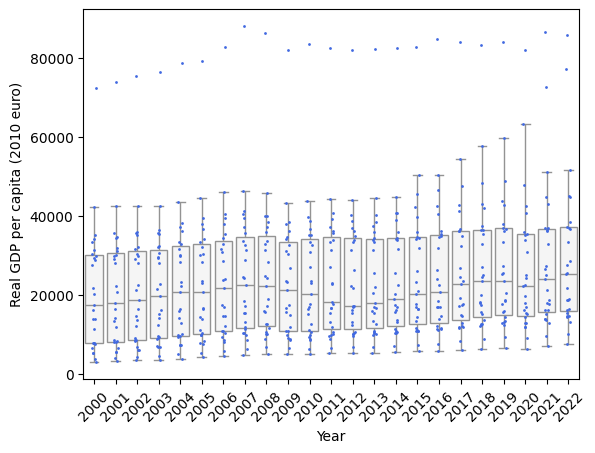

In [7]:
sns.boxplot(
    data_real_gdp, x="Year", y="Real GDP per capita", color="whitesmoke",  showfliers = False
)
ax = sns.stripplot(data_real_gdp, x="Year", y="Real GDP per capita", size=2, color="royalblue")
ax.set_ylabel("Real GDP per capita (2010 euro)")
ax.tick_params(axis='x', rotation=45)
ax.figure.savefig("fig_output/Fig_01.png", dpi=600)

In [8]:
data_real_gdp_pivot = pd.pivot(data_real_gdp, columns="Year", index="GeoName", values="Real GDP per capita")

def hp_filter(row):
    cycle, trend = hpfilter(row[1:], lamb=6.25)
    return trend

data_real_gdp_pivot = data_real_gdp_pivot.apply(hp_filter, axis=1)
data_real_gdp_pivot.to_csv("data/europe_filtered.csv")
data_real_gdp_pivot

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
GeoName,,,,,,,,,,,,,,,,,,,,,
AT,31626.025107,32103.675659,32609.162194,33172.932590,33782.368772,34390.783454,34906.310343,35240.157796,35414.524515,35573.183952,...,35934.674457,36037.939234,36201.655343,36432.543841,36693.860933,36916.455807,37051.359905,37150.971736,37425.872227,37819.286825
BE,29991.818656,30526.592616,31080.275592,31665.921779,32232.541279,32724.996710,33082.944084,33258.039939,33310.269761,33360.732645,...,33720.748586,33973.372884,34280.252159,34601.961905,34911.837269,35186.099496,35423.075867,35672.917741,36095.684343,36591.768056
BG,3174.239682,3421.443362,3674.368693,3938.506388,4210.648169,4476.624736,4715.763081,4907.930240,5046.471154,5158.661927,...,5446.870032,5563.720005,5711.297415,5883.784541,6073.556072,6277.181174,6498.660041,6750.443877,7065.998282,7422.717833
CY,20626.779867,21244.718989,21874.373332,22525.103080,23149.568683,23664.414096,23970.352289,23980.189974,23678.677496,23162.534806,...,21351.955745,21246.228737,21574.891802,22241.741745,23077.792680,23940.980045,24751.992448,25520.961687,26379.300773,27271.068844
CZ,11631.433356,12146.561885,12693.461078,13286.851695,13899.300725,14460.678887,14886.568782,15127.644390,15216.728685,15268.621540,...,15641.435108,15980.416699,16441.966750,16963.893952,17483.692315,17922.232819,18238.195670,18434.703827,18607.968940,18768.650045
DE,29549.281572,29731.962600,29965.958577,30310.270435,30770.145734,31302.788764,31793.380499,32166.655710,32466.808288,32860.167210,...,34158.655997,34583.451916,35013.458341,35436.557614,35808.078742,36064.701514,36197.813121,36258.848509,36382.792529,36532.014265
DK,42156.463892,42717.105947,43329.513779,44013.916215,44673.819874,45157.704784,45299.039791,45085.260977,44676.758057,44365.878990,...,44577.634568,45039.091408,45665.920045,46407.496932,47186.651313,47944.212924,48693.547290,49503.345870,50478.532555,51473.895896
EE,7979.025186,8778.465462,9586.061708,10387.815421,11131.958224,11714.271273,12020.622407,12019.396062,11872.477090,11833.046972,...,12625.128607,13042.375650,13490.044993,13961.954032,14439.112963,14876.619336,15252.112629,15574.173224,15902.243484,16215.098056
EL,18113.512630,18965.405459,19807.136267,20584.478160,21230.862441,21693.403908,21840.679366,21564.720997,20863.052285,19862.041352,...,17188.291473,16862.255282,16764.718662,16808.162763,16926.713749,17067.591739,17207.342656,17380.497742,17713.213415,18134.766456
